In [1010]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sympy
import control as ct
import scipy
from copy import deepcopy
plt.rcParams.update({'font.size': 18})
IMAGES_FOLDER_PATH = os.path.join(os.path.dirname(os.path.abspath("main.ipynb")), 'tex/images')
np.set_printoptions(suppress=True,precision=2)

## 1. Синтез эталонного регулятора

Согласно варианту:

$$
 A = \begin{bmatrix} 0 & 1 \\ 1 & 4 \end{bmatrix} \hspace{5mm} b_0 = 4 \hspace{5mm} t_p = 0.2 \hspace{5mm} \bar{\sigma} = 0 \% \hspace{5mm} g(t) = sign(\sin{0.3t}) + 1.5 
$$

Рассмотрим полином Ньютона первого порядка: $\lambda^2 + 2w_0\lambda + w_0^2$  

In [1011]:
A = np.array([
    [0., 1.],
    [1., 4.]
])
b_0 = 4
B = np.array([0., 4.]).reshape(-1, 1)

In [1012]:
def newthon_polynom(order, w_0):
    x = sympy.Symbol("x")
    num = np.ones(1)
    den = np.array(sympy.poly((x+w_0)**order).coeffs(), dtype=float)
    return ct.tf(num, den)

def compute_Am(t_p, sigma, x_0, delta = 0.01, order = 2):
    if sigma > 1:
        raise ValueError("Cannot handle case when sigma is more than 1. Use Butterworth polynomial instead.")
    
    w_0 = 1
    sys = newthon_polynom(order, w_0)
    t = np.linspace(0.0, 40.0, 1000)
    T, yout = ct.step_response(sys, T=t, X0=x_0)
   
    for i in range(1, len(yout)):
        if (abs(yout[-i] - 1.0) >= delta):
            break
        else:
            t_p_real = T[-i]

    w_0 = t_p_real / t_p

    
    tf = scipy.signal.TransferFunction([1], [1, 2 * w_0, w_0**2])

    return tf

In [1013]:
def goal_signal_generator(state, t, Am, bm, g):
    x = state
    dx = Am @ x + bm * g(t) 
    return dx

In [1014]:
def task1(y0, t, t_p, sigma, g, order, delta = 0.05):
    tf = compute_Am(t_p, sigma, y0, delta=delta, order=order)

    t, y, _ = scipy.signal.lsim(tf, U = [1] * t.shape[0], T = t )
   
    fig, axs = plt.subplots(1, 1, figsize=(7, 7))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)
    
    stable_value = np.max(y)
    axs.plot(t, np.ones_like(t) * stable_value, color='r', label='$y_{stable}$')
    axs.plot(t, y, color='b', label='$y$')
    axs.plot(t, np.ones_like(t) * (stable_value - delta * stable_value), color='c', linestyle='--', label='$\Delta$ neighborhood')
    axs.plot(t, np.ones_like(t) * (stable_value + delta * stable_value), color='c', linestyle='--')
    axs.plot([t_p, t_p], [np.min(y), stable_value - delta * stable_value], color = 'black', linestyle='--')
    
    axs.fill_between(t, np.ones_like(t) * (stable_value - delta * stable_value), np.ones_like(t) * (stable_value + delta * stable_value), color='C0', alpha=0.3) 
    axs.scatter([t_p], [stable_value - delta * stable_value], color = 'black')  
    
    axs.grid()
    axs.set(xlabel='t, с', ylabel='y')
    axs.legend()

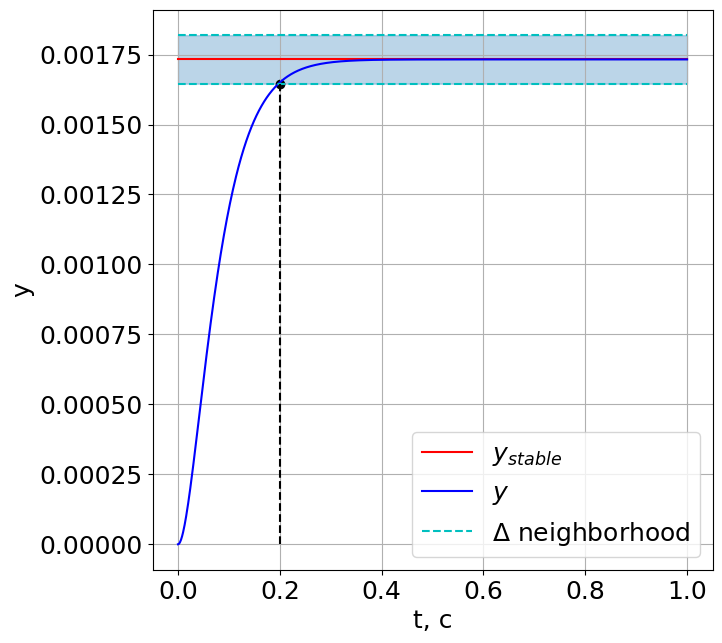

In [1015]:
y0 = [-0.01, -0.01]
t = np.linspace(0.0, 1., 1000)
g = lambda t: np.sign(np.sin(0.3*t)) + 1.5
# g = lambda t: 0.8 * np.sin(2.*t) + np.cos(0.8*t) + 2.
task1(y0, t, 0.2, 0, g, 2)

## 2. Синтез простейшего (физически не реализуемого) регулятора

In [1016]:
def model(t, x, A, B, g):
    return A@x + (B * g(t)).reshape(A.shape[0])

def system(t, x, A, B, theta, kappa, g):
    u = theta.T @ x + 1 / kappa * g(t)
    return A@x + (B * u).reshape(A.shape[0])

In [1017]:
def task2(y0, t, t_p, sigma, g, order, fake_A = A, fake_B = B, delta = 0.05):
    tf = compute_Am(t_p, sigma, y0, delta=delta, order=order)
    A_m, B_m, C_m, D_m = tf.to_ss().A, tf.to_ss().B, tf.to_ss().C, tf.to_ss().D
    A_m, B_m, C_m, D_m = np.rot90(A_m, k=2), np.rot90(B_m, k=2), np.rot90(C_m, k=2), np.rot90(D_m, k=2)

    theta = -((-A_m[-1, :] + A[-1, :]) / b_0).reshape(A.shape[0], 1)
    kappa = b_0 / B_m[-1, 0] 

    t_span = [0, 20]
    
    data_model= solve_ivp(model, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(A_m, B_m, g))
    y0 = np.array([0, 0])
    data = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 1000), y0=y0, args=(fake_A, fake_B, theta, kappa, g))

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)

    for i in range(2):
        axs[i, 0].plot(data.t, data_model.y[i, :], color='r', linewidth=2, label=f'$xm_{i}$')
        axs[i, 0].plot(data.t, data.y[i, :], '--', color='b', linewidth=2, label=f'$x_{i}$')
        axs[i, 0].grid()
        axs[i, 0].set(xlabel='t, с', ylabel='x')
        axs[i, 0].legend()

        axs[i, 1].plot(data.t, data_model.y[i, :] - data.y[i, :], color='orange', linewidth=2, label=f'$\\varepsilon_{i}$')
        axs[i, 1].grid()
        axs[i, 1].set(xlabel='t, с', ylabel='x')
        axs[i, 1].legend()


In [1018]:
A

array([[0., 1.],
       [1., 4.]])

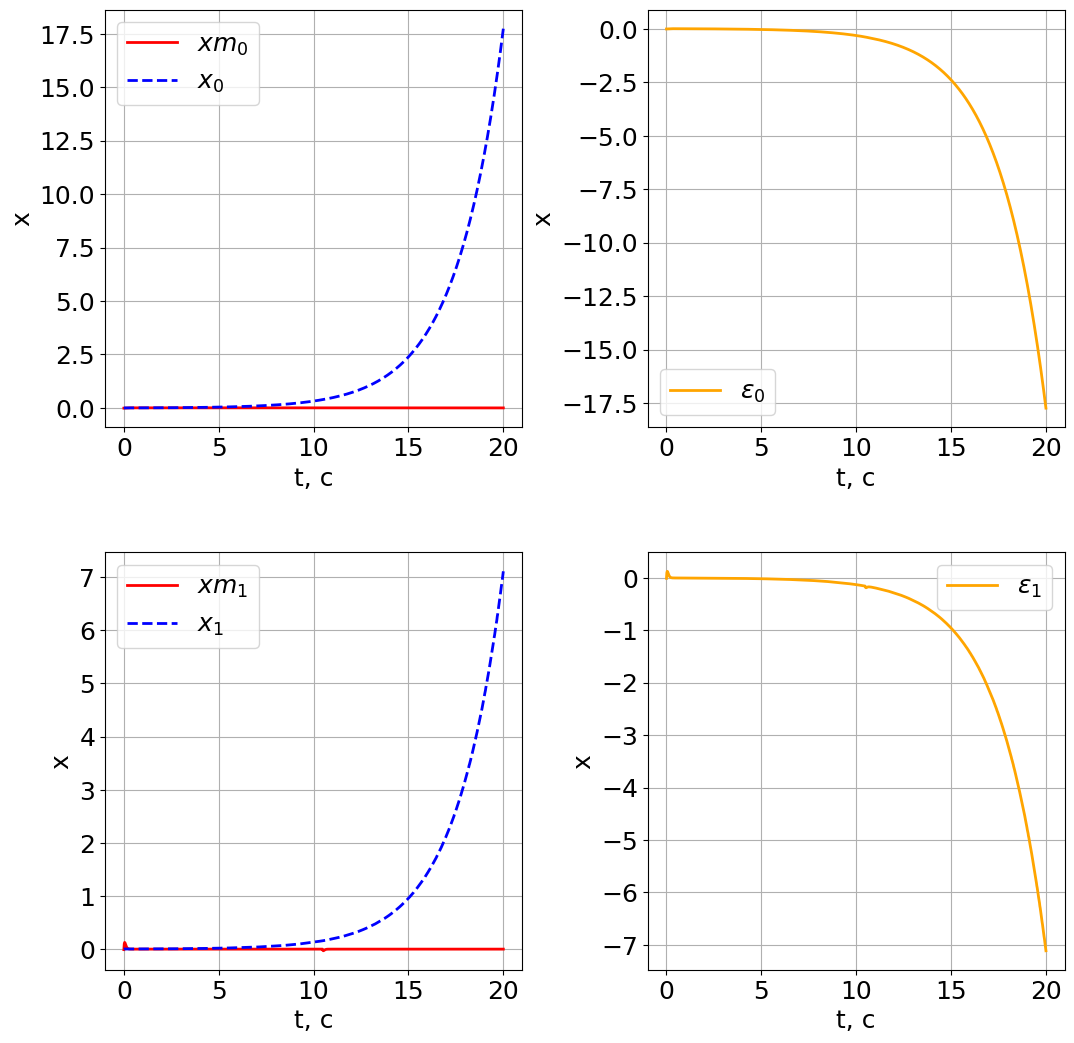

In [1019]:
t = np.linspace(0.0, 60., 10000)
# task2(y0, t, 0.2, 0, g, 2)
fake_A = deepcopy(A)
fake_B = deepcopy(B)

# task2(y0, t, 0.2, 0, g, 2, fake_A=fake_A + 0.01, fake_B=fake_B)
# fake_B[-1] = 0.25
# fake_A[1, 1] = 1
fake_A[1, 0] = 1000
fake_A[1, 1] = -1000
task2(y0, t, 0.2, 0, g, 2, fake_A=fake_A, fake_B=fake_B)

## 3. Синтез адаптивного регулятора

### 3.1

In [1020]:
def d_theta_hat(x, P, gamma, B, e):
    x = x.reshape(2, 1)
    e = e.reshape(2, 1)
    return (gamma * x @ B.T @ P @ e).reshape(-1)

def system(t, x, A, B, A_m, B_m, kappa, g, gamma, P):
    theta_hat = x[-2:]
    x_m = x[:2]
    x = x[2:4]
    e = x_m - x
    u = theta_hat.T @ x + 1 / kappa * g(t)
   
    return np.hstack([model(t, x_m, A_m, B_m, g),
                        A@x + (B * u).reshape(A.shape[0]),
                        d_theta_hat(x, P, gamma, B, e)])

In [1021]:
def task3_1(y0, t, t_p, sigma, gamma, g, order, fake_A = A, fake_B = B, delta = 0.05):
    tf = compute_Am(t_p, sigma, y0[:2], delta=delta, order=order)
    A_m, B_m, C_m, D_m = tf.to_ss().A, tf.to_ss().B, tf.to_ss().C, tf.to_ss().D
    A_m, B_m, C_m, D_m = np.rot90(A_m, k=2), np.rot90(B_m, k=2), np.rot90(C_m, k=2), np.rot90(D_m, k=2)

    Q = np.diag([200000.0, 200000.0])
    P = scipy.linalg.solve_sylvester(A_m.T, A_m, -Q)
    
    kappa = b_0 / B_m[-1, 0] 
    t_span = [0, 250]
    
    data = solve_ivp(system, t_span=t_span, t_eval=np.linspace(*t_span, 10000), y0=y0, args=(fake_A, fake_B, A_m, B_m, kappa, g, gamma, P))

    t = data.t
    state =  data.y
    x_m = state[:2]
    x = state[2:4]
    theta =  -((-A_m[-1, :] + fake_A[-1, :]) / b_0).reshape(A.shape[0], 1)
    state =  data.y
    theta_tilda = theta - state[-2:]

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.3)

    for i in range(2):
        axs[0, i].plot(data.t, x_m[i, ], color='r', linewidth=2, label=f'$xm_{i}$')
        axs[0, i].plot(data.t, x[i, ], '--', color='b', linewidth=2, label=f'$x_{i}$')
        axs[0, i].grid()
        axs[0, i].set(xlabel='t, с', ylabel='x')
        axs[0, i].legend()

        axs[1, i].plot(data.t, x_m[i, ] - x[i, ], color='orange', linewidth=2, label=f'$\\varepsilon_{i}$')
        axs[1, i].grid()
        axs[1, i].set(xlabel='t, с', ylabel='x')
        axs[1, i].legend()

    axs[0, 2].plot(data.t, state[-2:][0, ], color='r', linewidth=2, label='$\\hat{\\theta}_1$')
    axs[0, 2].plot(data.t, np.ones_like(data.t)*theta[0], '--', color='b', linewidth=2, label='$\\theta_1$')
    axs[0, 2].plot(data.t, state[-2:][1, ], color='orange', linewidth=2, label='$\\hat{\\theta}_2$')
    axs[0, 2].plot(data.t, np.ones_like(data.t)*theta[1], '--', color='green', linewidth=2, label='$\\theta_2$')
    axs[0, 2].grid()
    axs[0, 2].set(xlabel='t, с', ylabel='x')
    axs[0, 2].legend()

    axs[1, 2].plot(data.t, theta_tilda[0,], color='orange', linewidth=2, label='$\\tilde{\\theta}_1$')
    axs[1, 2].plot(data.t, theta_tilda[1,], color='r', linewidth=2, label='$\\tilde{\\theta}_2$')
    axs[1, 2].grid()
    axs[1, 2].set(xlabel='t, с', ylabel='x')
    axs[1, 2].legend()



In [1022]:
y0 = np.array([-0.01, -0.01, 0., 0., 0., 0.])
t = np.linspace(0.0, 100., 10000)
task3_1(y0, t, 0.2, 0, 100000, g, 2)
fake_A = deepcopy(A)
fake_B = deepcopy(B)



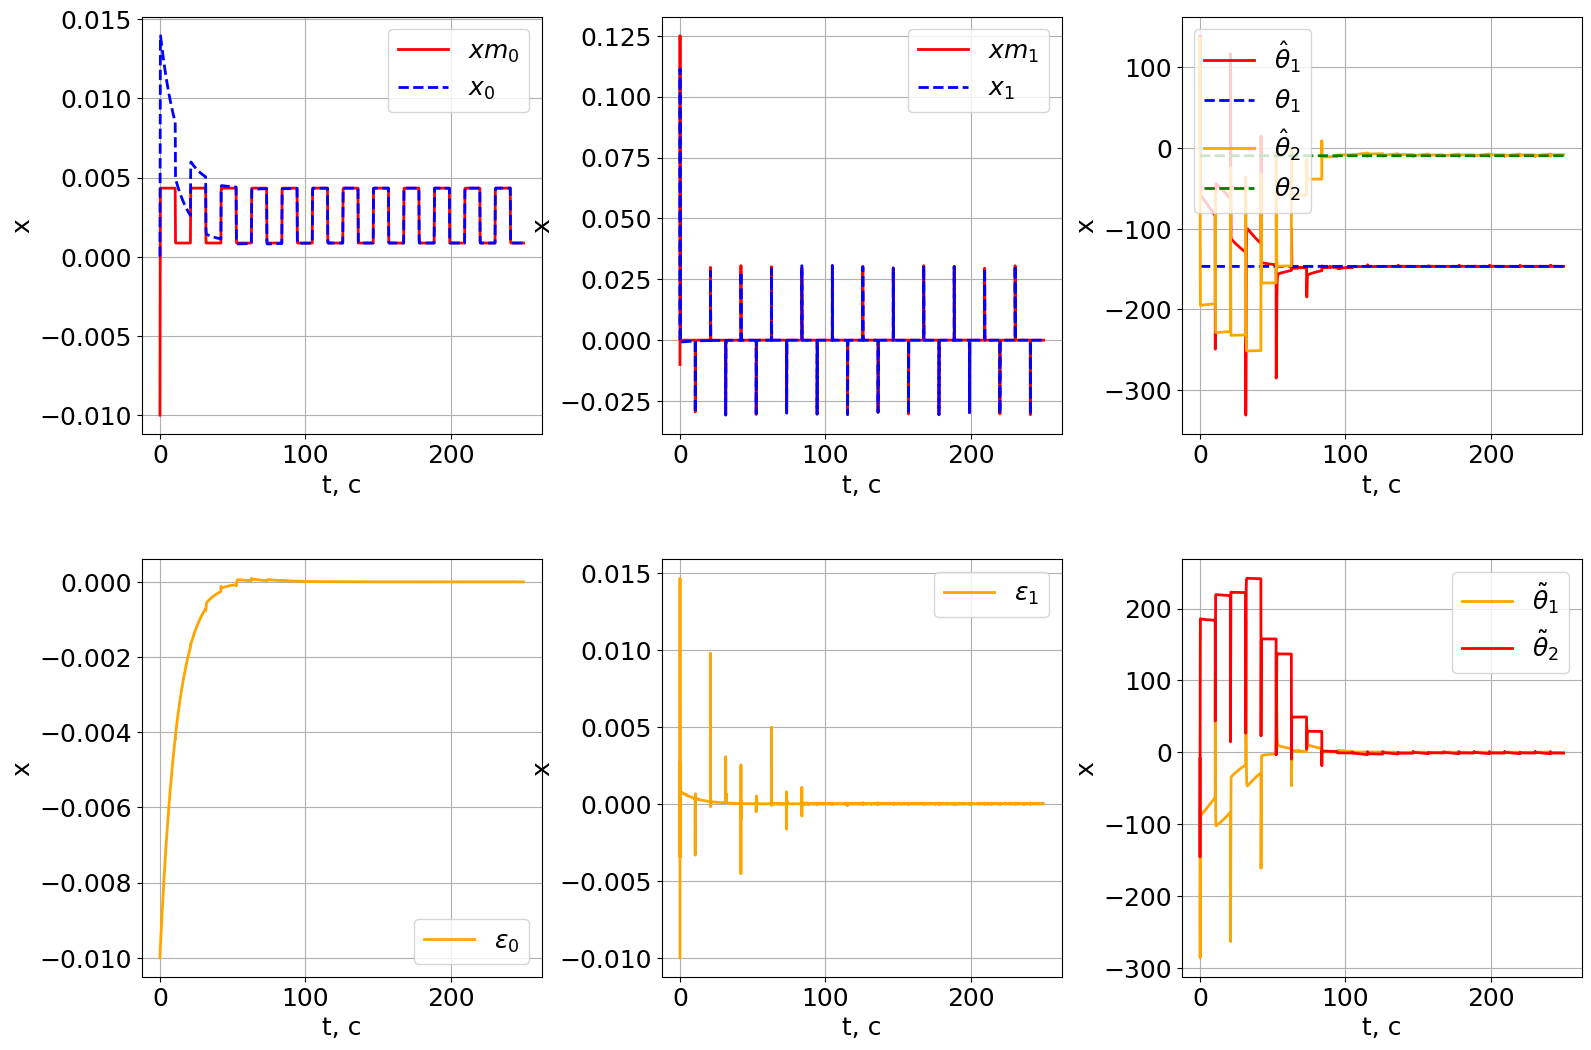

In [ ]:
fake_A[1, 0] = 10
fake_A[1, 1] = -10
task3_1(y0, t, 0.2, 0, 100000, g, 2, fake_A=fake_A, fake_B=fake_B)

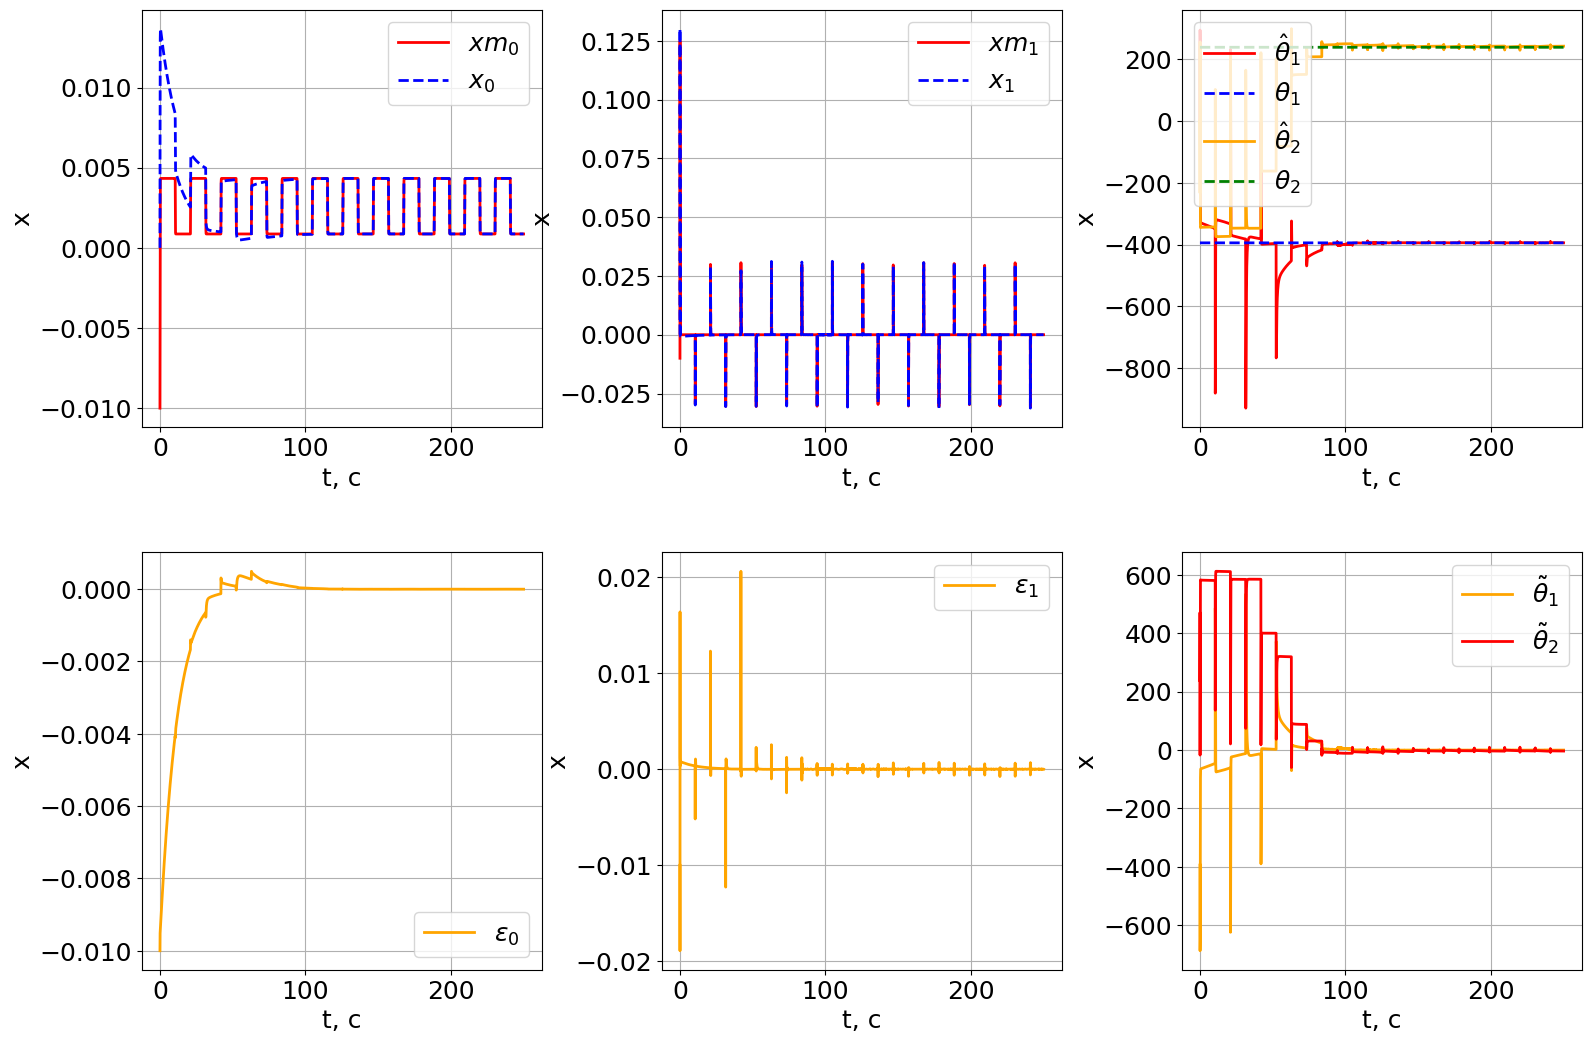

In [ ]:
# # fake_B[-1] = 0.25
# fake_A[0, 1] = -0.01
fake_A[1, 0] = 1000
fake_A[1, 1] = -1000
task3_1(y0, t, 0.2, 0, 100000, g, 2, fake_A=fake_A, fake_B=fake_B)

### 3.2

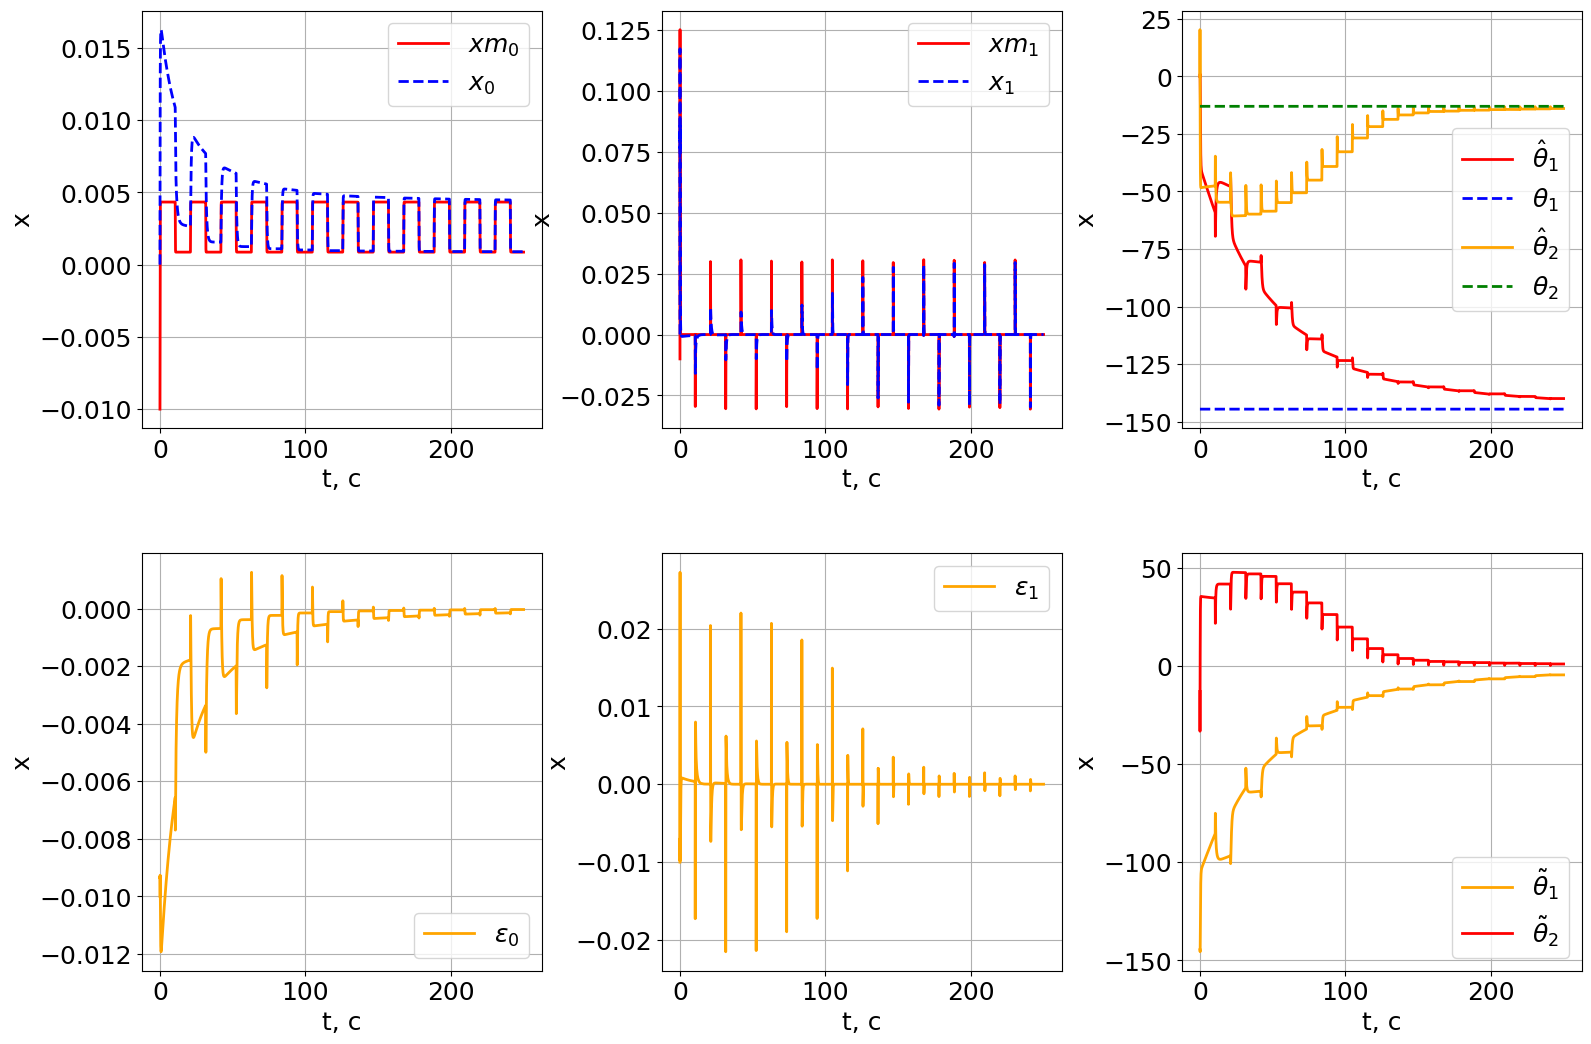

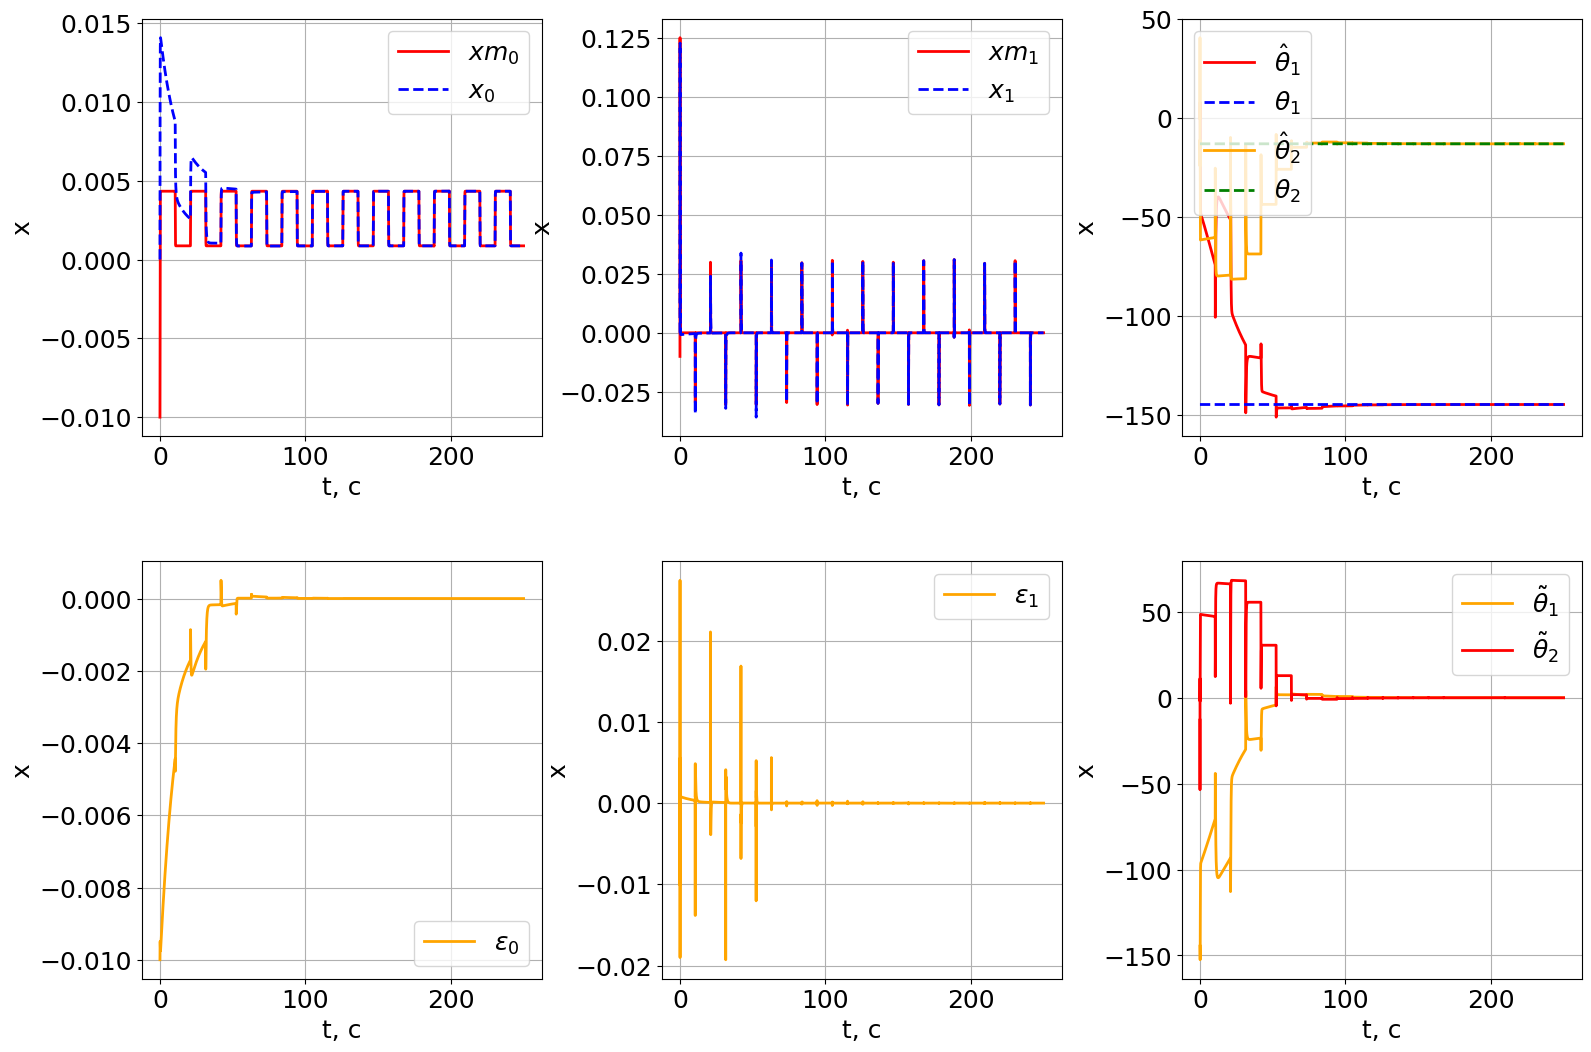

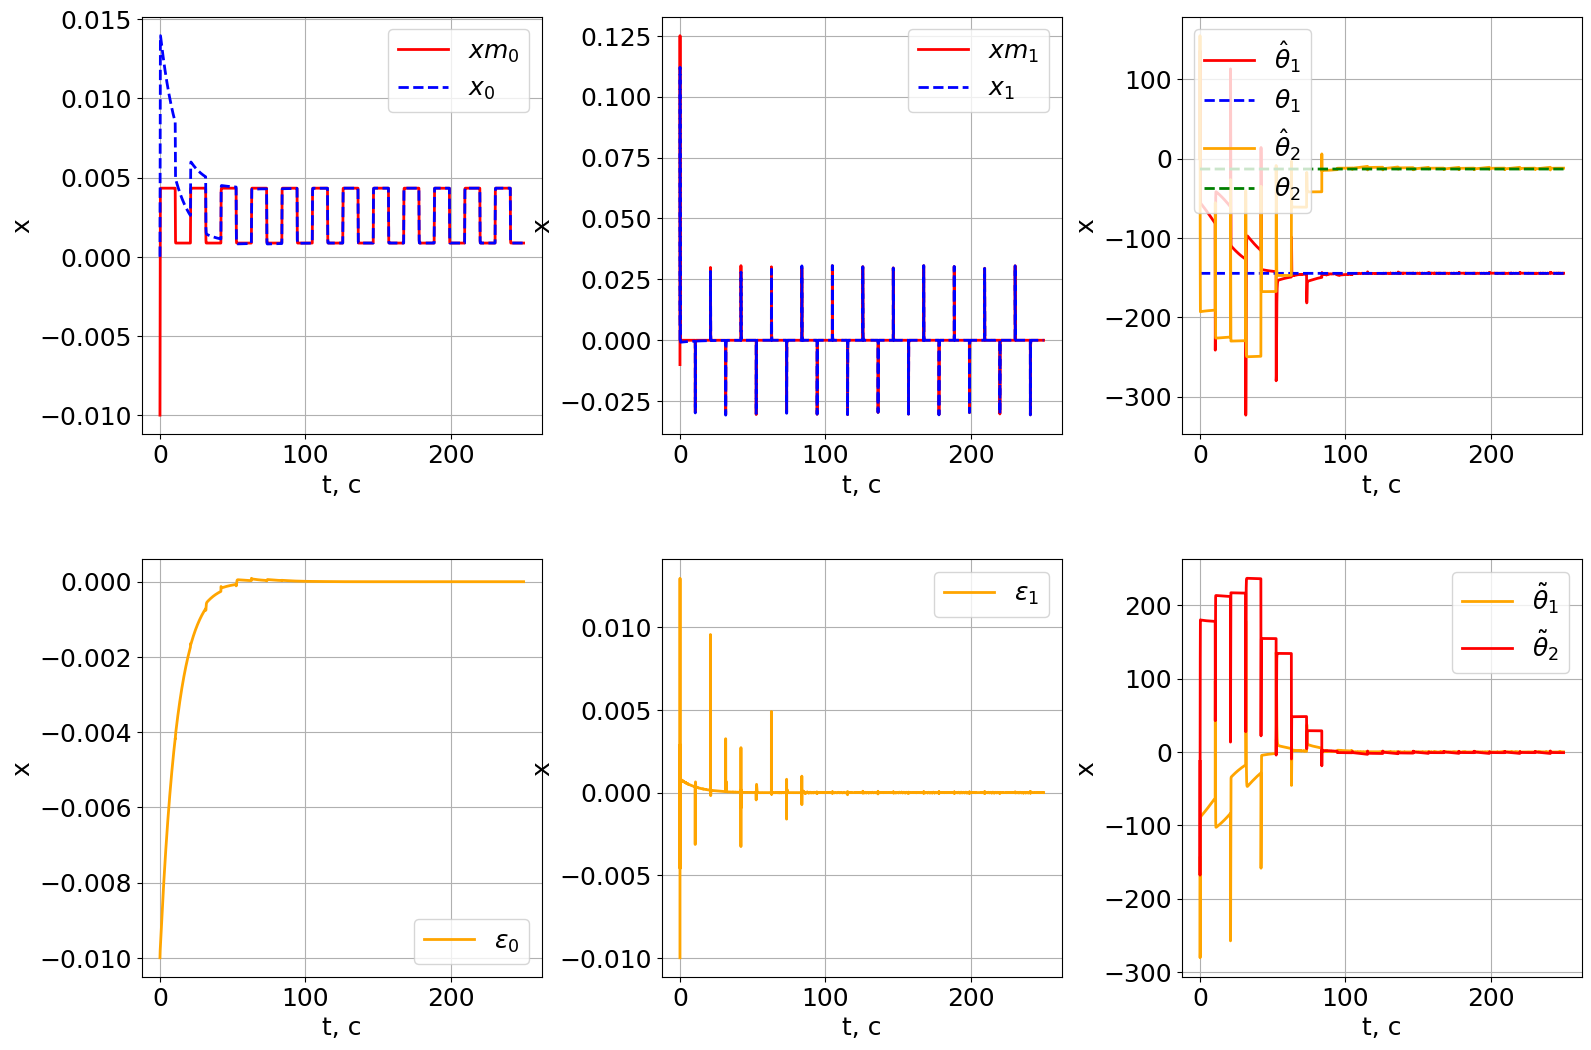

In [ ]:
for gamma in [100, 1000, 100000]:
    task3_1(y0, t, 0.2, 0, gamma, g, 2)

### 3.3

KeyboardInterrupt: 

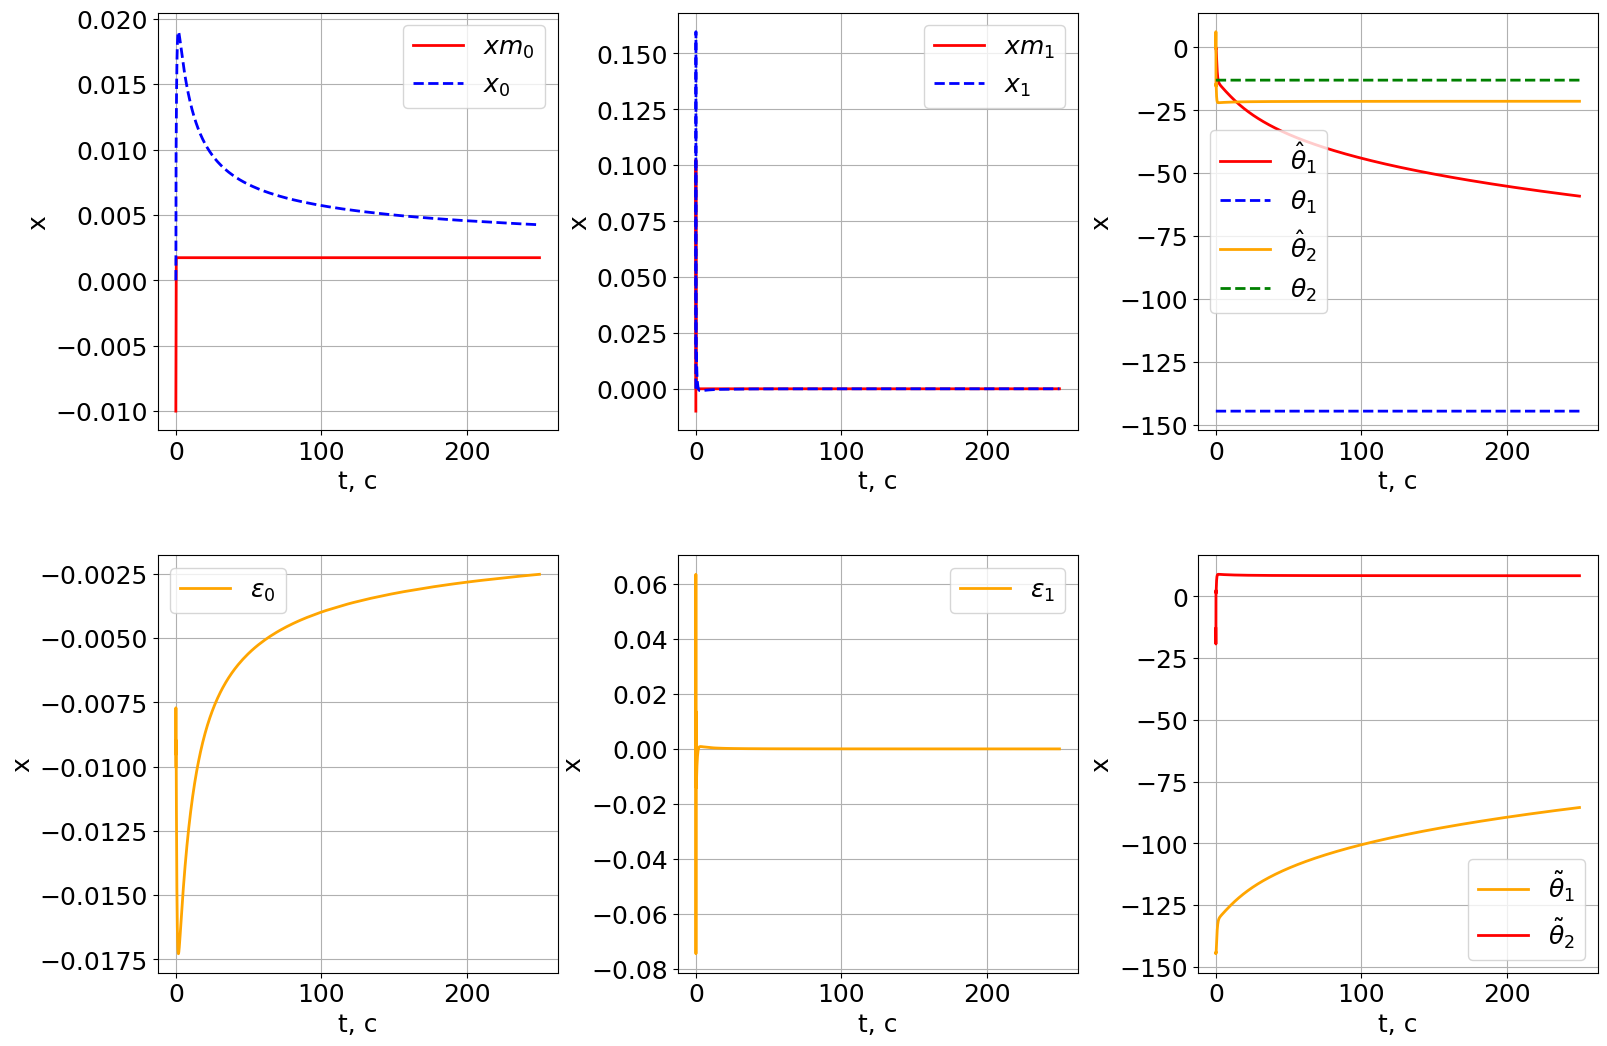

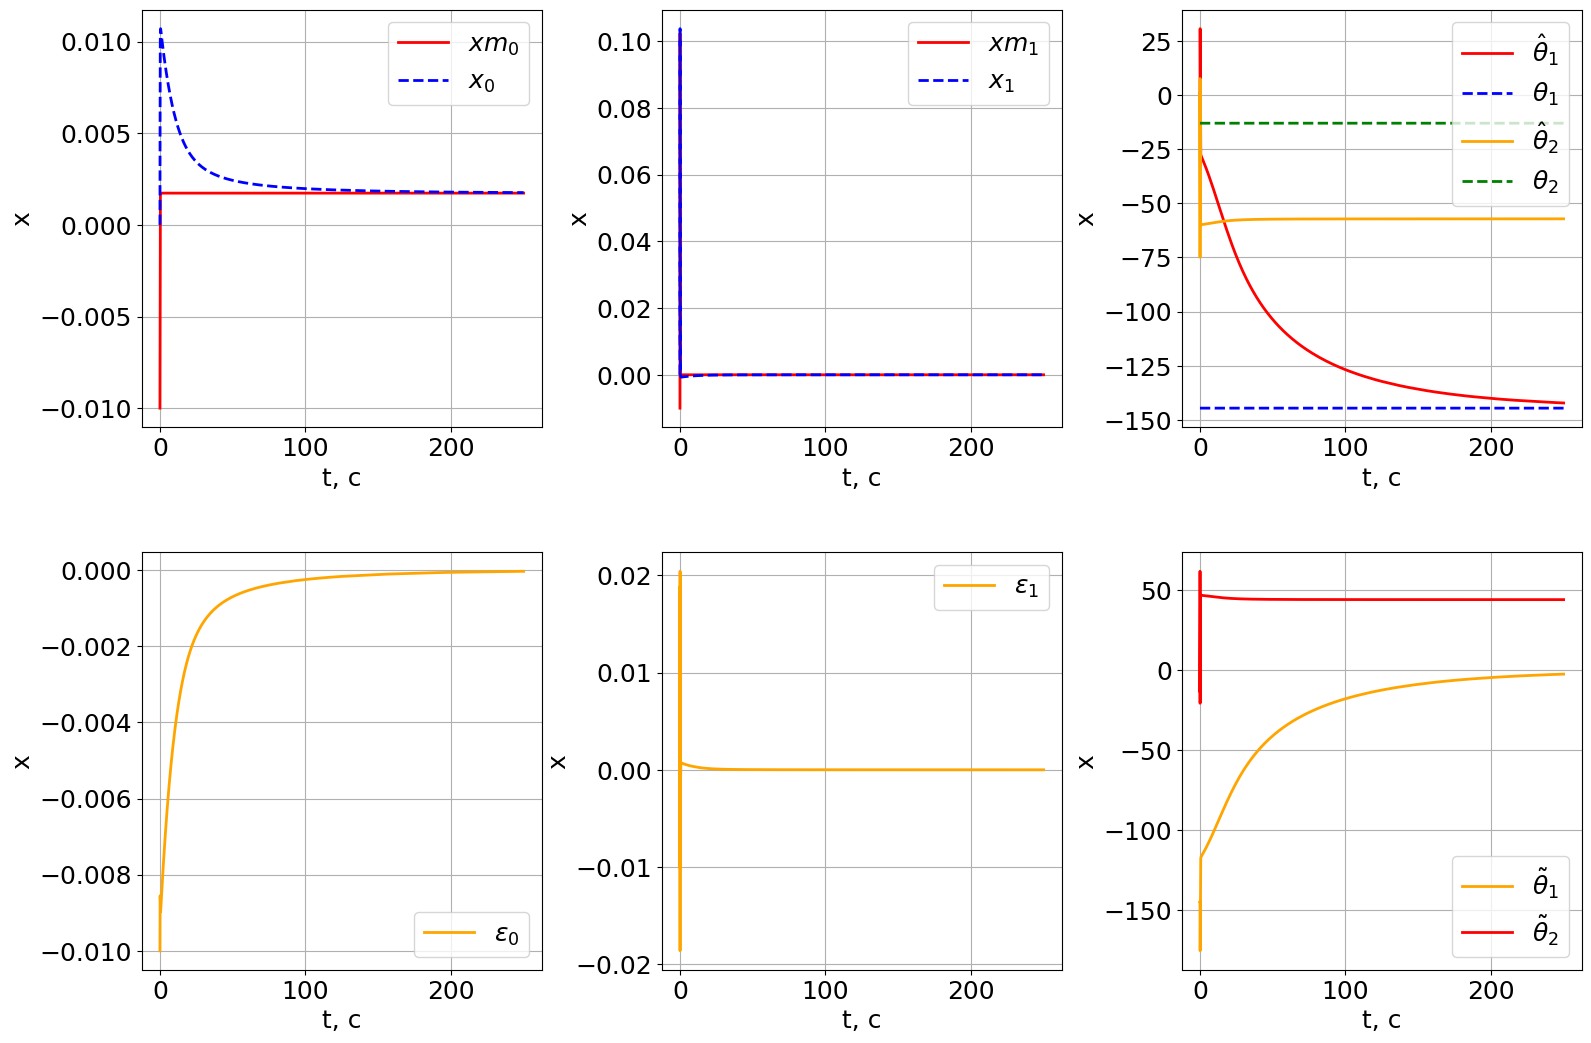

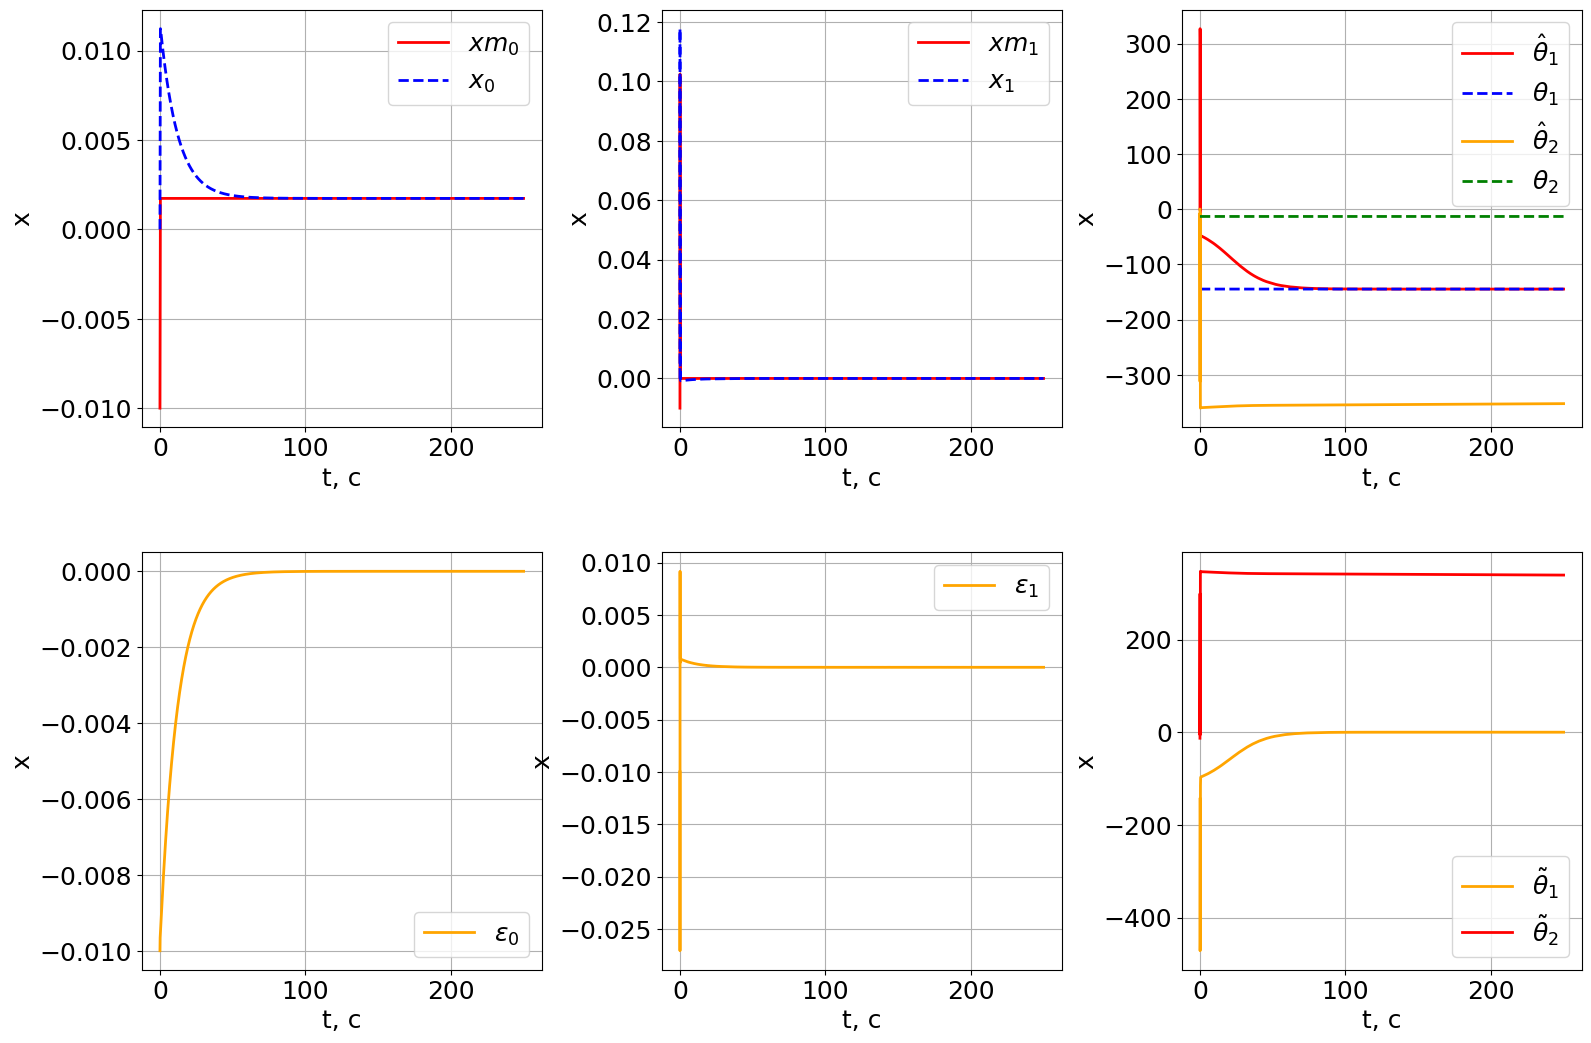

In [ ]:
g = lambda t: 1
for gamma in [100, 1000, 100000]:
    task3_1(y0, t, 0.2, 0, gamma, g, 2)